<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Effortful Retrieval Experiments**

**Author**: Elizabeth Zhong

We will conduct a series of experiments to evaluate memory retrieval performance in CNNs under different conditions of retrieval difficulty. To vary retrieval difficulty, each experiment manipulates a key difficulty variable, interstimulus interval (ISI), noise level, and occlusion. To evaluate model performance, each experiment computes classification accuracy and learning period counts. We will be using a standard pre-trained `ResNet-18` CNN and fine-tune using the CIFAR-10 image dataset (publicly available via `torchvision.datasets`). 

## **Table of Contents**

1. Notebook Setup
2. Experiment Setup
3. Experimental Results
    - Experiment 1: Spaced vs. Massed
    - Experiment 2: Noise Level
    - Experiment 3: Occlusion
4. Interpretation

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **1. Notebook Setup**

In [ ]:
# Library imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from tqdm import tqdm
from scipy.stats import ttest_ind

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **2. Experiment Setup**

#### **Dataset Label Information**

In [ ]:
dataset = CIFAR10(root='./data', train=True, download=True)

num_classes = len(set(dataset.targets))
print(f"Number of labels: {num_classes}")

label_counts = Counter(dataset.targets)
print(label_counts)

Number of labels: 10
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


**Note**: This dataset is already balanced.

In [ ]:
BATCH_SIZE = 64

### **Creating 2-Label Batched Dataloader**

To ensure that our spaced vs. massed learning experiments do not depend on the training dataset size, we will create 2-label datasets (i.e. a dataset with only images that have labels 1 and 2). Given our dataset has 10 labels, we will be creating 5 of these datasets (1-2, 3-4, 5-6, 7-8, 9-10).

In [79]:
def get_two_label_batches(dataset, batch_size=512, shuffle_within_batch=True, shuffle_batches=True, seed=42):
    assert batch_size % 2 == 0, "Batch size must be divisible by 2."
    random.seed(seed)
    label_to_samples = defaultdict(list)

    # group by label and label pairs
    for img, label in dataset:
        label_to_samples[label].append((img, label))
    label_pairs = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]

    # one batch per label pair
    batches = []
    for l1, l2 in label_pairs:
        samples1 = random.sample(label_to_samples[l1], batch_size // 2)
        samples2 = random.sample(label_to_samples[l2], batch_size // 2)
        combined = samples1 + samples2

        if shuffle_within_batch:
            random.shuffle(combined)

        images, labels = zip(*combined)
        batch = (torch.stack(images), torch.tensor(labels))
        batches.append(batch)

    return batches

In [ ]:
transform = transforms.ToTensor()
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
batches = get_two_label_batches(dataset, batch_size=BATCH_SIZE)
loader = DataLoader(batches, batch_size=None)

#### **Defining the CNN Model**

In [81]:
def get_pretrained_cnn():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer

### **Training and Evaluation Functions**

In [82]:
def train_on_batch(model, batch, criterion, optimizer):
    model.train()
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [83]:
def evaluate_batch(model, batch):
    model.eval()
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        accuracy = (preds == labels).float().mean().item() * 100
    return accuracy

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Experiments**

### **Experiment 1: Spaced vs. Massed Learning**

**Massed Learning**
- For each 2-label datasets:
    1. Initialize a fresh CNN.
    2. After training the model on each of the 5 datasets each of the five 2-label datasets, test the model on a random sample of the same dataset.
    3. If the model does not meet the accuracy threshold, retrain the model on the same dataset.
    4. Record the number of learning periods needed until the accuracy threshold is reached.
- Take the average number of learning periods across the 5 datasets.
- Repeat for 100 trials.
- Calculate the mean average number of learning periods and the 95% confidence interval.

**Spaced Learning**
- For each 2-label datasets (target dataset):
    1. Initialize a fresh CNN.
    2. Train the model on all 5 datasets, then test the model on a random sample of the target dataset.
    3. If the model does not meet the accuracy threshold, retrain the model on the same dataset.
    4. Record the number of learning periods needed until the accuracy threshold is reached.
- Take the average number of learning periods across the 5 datasets.
- Repeat for 100 trials.
- Calculate the mean average number of learning periods and the 95% confidence interval.

**Final Metrics**
- Bar chart comparing the mean average number of learning periods for massed and spaced learning with 95% error bars.
- Conduct t-test and calculate p-value. Determine statistical significance.


In [ ]:
ACCURACY_THRESHOLD = 80
MAX_LEARNING_PERIODS = 10
NUM_TRIALS = 5

### **Massed and Spaced Learning**

In [84]:
def run_trial_massed(batch, threshold=ACCURACY_THRESHOLD):
    model, criterion, optimizer = get_pretrained_cnn()
    learning_periods = 0

    for _ in range(MAX_LEARNING_PERIODS):
        acc = evaluate_batch(model, batch)
        if acc >= threshold:
            break
        train_on_batch(model, batch, criterion, optimizer)
        learning_periods += 1
    return learning_periods

In [85]:
def run_trial_spaced(batches, target_idx, threshold=ACCURACY_THRESHOLD):
    model, criterion, optimizer = get_pretrained_cnn()
    learning_periods = 0
    target_batch = batches[target_idx]

    for _ in range(MAX_LEARNING_PERIODS):
        for batch in batches:
            train_on_batch(model, batch, criterion, optimizer)
        acc = evaluate_batch(model, target_batch)
        if acc >= threshold:
            break
        learning_periods += 1
    return learning_periods

### **Run Experiment**

In [ ]:
def run_experiment1(thresholds):
    summary = {
        "thresholds": [],
        "massed_means": [],
        "spaced_means": [],
        "massed_cis": [],
        "spaced_cis": [],
        "p_values": []
    }

    for threshold in thresholds:
        print(f"\nRunning trials for accuracy threshold = {threshold}%")
        massed_results, spaced_results = [], []
        for _ in tqdm(range(NUM_TRIALS), desc=f"Threshold {threshold}"):
            trial_massed = [run_trial_massed(batches[i], threshold) for i in range(5)]
            trial_spaced = [run_trial_spaced(batches, i, threshold) for i in range(5)]
            massed_results.append(np.mean(trial_massed))
            spaced_results.append(np.mean(trial_spaced))

        massed_arr = np.array(massed_results)
        spaced_arr = np.array(spaced_results)

        summary["thresholds"].append(threshold)
        summary["massed_means"].append(massed_arr.mean())
        summary["spaced_means"].append(spaced_arr.mean())
        summary["massed_cis"].append(1.96 * massed_arr.std() / np.sqrt(NUM_TRIALS))
        summary["spaced_cis"].append(1.96 * spaced_arr.std() / np.sqrt(NUM_TRIALS))
        _, p = ttest_ind(massed_arr, spaced_arr)
        summary["p_values"].append(p)

    return summary

In [ ]:
thresholds = list(range(50, 100, 10))
threshold_summary = run_experiment1(thresholds)


Running trials for accuracy threshold = 50%


Threshold 50: 100%|██████████| 5/5 [06:59<00:00, 83.96s/it] 



Running trials for accuracy threshold = 60%


Threshold 60: 100%|██████████| 5/5 [12:33<00:00, 150.60s/it]



Running trials for accuracy threshold = 70%


Threshold 70: 100%|██████████| 5/5 [07:30<00:00, 90.19s/it]



Running trials for accuracy threshold = 80%


Threshold 80: 100%|██████████| 5/5 [08:43<00:00, 104.79s/it]



Running trials for accuracy threshold = 90%


Threshold 90: 100%|██████████| 5/5 [09:30<00:00, 114.03s/it]


**Plotting**

In [94]:
def plot_threshold_sweep(summary):
    thresholds = summary["thresholds"]

    plt.figure(figsize=(10, 5))

    # Plot learning periods
    plt.subplot(1, 2, 1)
    plt.errorbar(thresholds, summary["massed_means"], yerr=summary["massed_cis"], label="Massed", fmt='-o', capsize=4)
    plt.errorbar(thresholds, summary["spaced_means"], yerr=summary["spaced_cis"], label="Spaced", fmt='-s', capsize=4)
    plt.title("Learning Periods vs. Accuracy Threshold")
    plt.xlabel("Accuracy Threshold (%)")
    plt.ylabel("Mean Learning Periods")
    plt.grid(True)
    plt.legend()

    # Plot p-values
    plt.subplot(1, 2, 2)
    plt.plot(thresholds, summary["p_values"], marker='x', color='purple')
    plt.axhline(y=0.05, color='red', linestyle='--', label='p = 0.05')
    plt.title("P-values Across Thresholds")
    plt.xlabel("Accuracy Threshold (%)")
    plt.ylabel("P-value")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

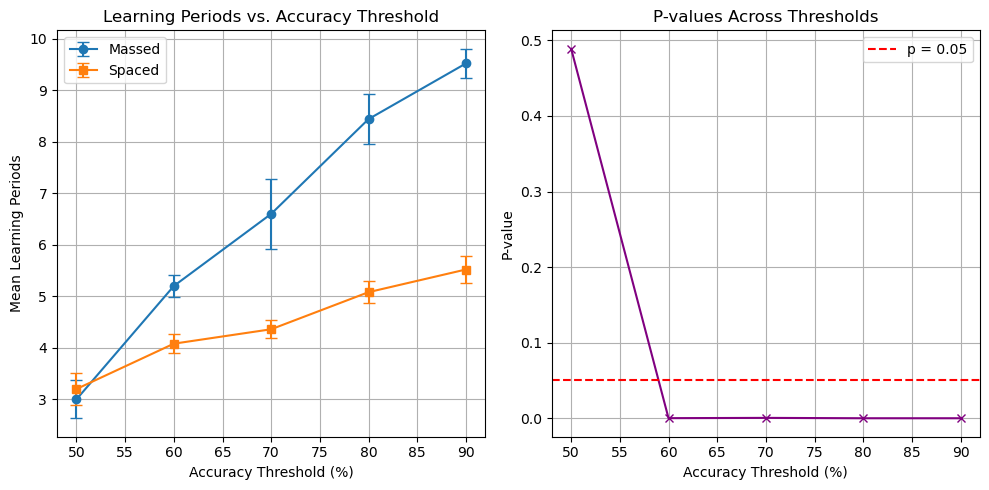

In [95]:
plot_threshold_sweep(threshold_summary)

_________

## **Experiment 2: Noise Levels in Images**

**Noise Level Learning**

Trial Protocol
1. Initialize a fresh CNN.
2. Introduce noise to the 2-label dataset and train the model on the noisy dataset. Test the model on the non-noisy dataset.
3. If the model does not meet the accuracy threshold, retrain the model.
4. Record the number of learning periods needed until the accuracy threshold is reached.

Conduct 100 trials for each noise level. Calculate the mean average number of learning periods and the 95% confidence interval.

**Final Metrics**
- Line chart with the mean average number of learning periods on the y-axis and noise level on the x-axis. Add 95% error bars.
- Conduct t-test and calculate p-value. Determine statistical significance.

In [ ]:
MAX_LEARNING_PERIODS = 10
NUM_TRIALS = 5
NOISE_LEVELS = [0.0, 0.1, 0.3, 0.5]
THRESHOLDS = list(range(50, 100, 10))

In [109]:
def get_two_label_batch(dataset, labels=(0, 1), batch_size=512, seed=42):
    random.seed(seed)
    label_to_samples = defaultdict(list)
    for img, label in dataset:
        label_to_samples[label].append((img, label))
    l1, l2 = labels
    samples1 = random.sample(label_to_samples[l1], batch_size // 2)
    samples2 = random.sample(label_to_samples[l2], batch_size // 2)
    combined = samples1 + samples2
    random.shuffle(combined)
    images, labels = zip(*combined)
    return (torch.stack(images), torch.tensor(labels))

In [110]:
clean_batch = get_two_label_batch(dataset)

#### **Add Gaussian Noise**

In [111]:
class AddGaussianNoise(object):
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.sigma
        return torch.clamp(tensor + noise, 0., 1.)

In [112]:
def apply_noise(batch, sigma):
    images, labels = batch
    noisy_images = torch.stack([AddGaussianNoise(sigma)(img) for img in images])
    return (noisy_images, labels)

In [124]:
def run_trial_noise_level(noise_sigma, threshold=ACCURACY_THRESHOLD):
    model, criterion, optimizer = get_pretrained_cnn()
    learning_periods = 0
    for _ in range(MAX_LEARNING_PERIODS):
        acc = evaluate_batch(model, clean_batch)
        if acc >= threshold:
            break
        noisy_batch = apply_noise(clean_batch, sigma=noise_sigma)
        train_on_batch(model, noisy_batch, criterion, optimizer)
        learning_periods += 1
    return learning_periods

### **Run Experiment**

In [139]:
def run_experiment_noise_vs_thresholds(thresholds, noise_levels):
    results = {
        "means": {sigma: [] for sigma in noise_levels},
        "all_trials": {sigma: [] for sigma in noise_levels},
        "p_values": {sigma: [] for sigma in noise_levels if sigma != 0.0}
    }

    for threshold in thresholds:
        print(f"\nThreshold = {threshold}%")
        trial_data = {}
        for sigma in noise_levels:
            print(f"  Noise σ = {sigma}")
            trials = []
            for _ in tqdm(range(NUM_TRIALS), desc=f"Thresh={threshold}, σ={sigma}", leave=False):
                lp = run_trial_noise_level(sigma, threshold)
                trials.append(lp)
            results["means"][sigma].append(np.mean(trials))
            results["all_trials"][sigma].append(trials)
            trial_data[sigma] = trials

        # Compare each noise level to baseline (σ=0.0)
        for sigma in noise_levels:
            if sigma != 0.0:
                t_stat, p_val = ttest_ind(trial_data[0.0], trial_data[sigma])
                results["p_values"][sigma].append(p_val)

    return results

In [140]:
summary_matrix_update = run_experiment_noise_vs_thresholds(THRESHOLDS, NOISE_LEVELS)


Threshold = 50%
  Noise σ = 0.0


Thresh=50, σ=0.0:   0%|          | 0/5 [00:00<?, ?it/s]/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Noise σ = 0.1


  Noise σ = 0.3


  Noise σ = 0.5



Threshold = 60%
  Noise σ = 0.0


  Noise σ = 0.1


  Noise σ = 0.3


  Noise σ = 0.5



Threshold = 70%
  Noise σ = 0.0


  Noise σ = 0.1


  Noise σ = 0.3


  Noise σ = 0.5



Threshold = 80%
  Noise σ = 0.0


  Noise σ = 0.1


  Noise σ = 0.3


  Noise σ = 0.5


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Threshold = 90%
  Noise σ = 0.0


  Noise σ = 0.1


  Noise σ = 0.3


  Noise σ = 0.5


#### **Plotting**

In [141]:
def plot_noise_threshold_matrix(summary_matrix, thresholds):
    plt.figure(figsize=(12, 6))

    # Plot mean learning periods
    plt.subplot(1, 2, 1)
    for sigma, values in summary_matrix["means"].items():
        plt.plot(thresholds, values, marker='o', label=f"σ={sigma}")
    plt.xlabel("Accuracy Threshold (%)")
    plt.ylabel("Mean Learning Periods")
    plt.title("Learning Periods vs. Accuracy Threshold")
    plt.legend()
    plt.grid(True)

    # Plot p-values
    plt.subplot(1, 2, 2)
    for sigma, pvals in summary_matrix["p_values"].items():
        plt.plot(thresholds, pvals, marker='x', label=f"σ={sigma}")
    plt.axhline(y=0.05, color='red', linestyle='--', label="p = 0.05")
    plt.xlabel("Accuracy Threshold (%)")
    plt.ylabel("P-value (vs. σ=0.0)")
    plt.title("Statistical Significance vs. Accuracy Threshold")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

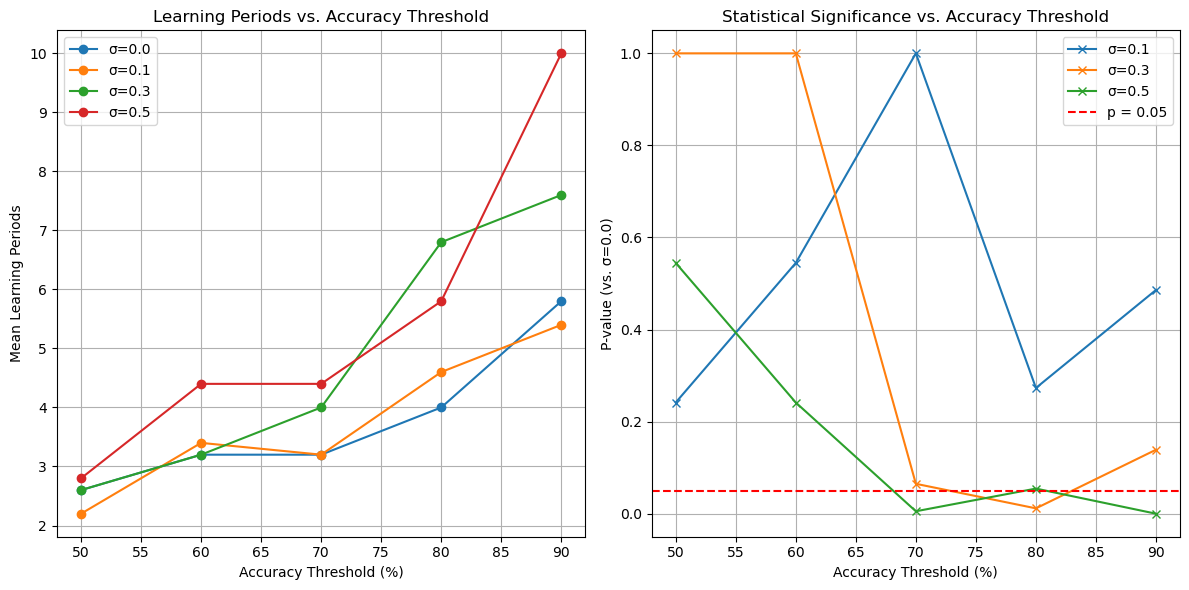

In [142]:
plot_noise_threshold_matrix(summary_matrix_update, THRESHOLDS)

_________

## **Experiment 3: Occlusion in Images**

**Noise Level Learning**

Trial Protocol
1. Initialize a fresh CNN.
2. Introduce noise to the 2-label dataset and train the model on the noisy dataset. Test the model on the non-noisy dataset.
3. If the model does not meet the accuracy threshold, retrain the model.
4. Record the number of learning periods needed until the accuracy threshold is reached.

Conduct 100 trials for each noise level. Calculate the mean average number of learning periods and the 95% confidence interval.

**Final Metrics**
- Line chart with the mean average number of learning periods on the y-axis and noise level on the x-axis. Add 95% error bars.
- Conduct t-test and calculate p-value. Determine statistical significance.

In [274]:
MAX_LEARNING_PERIODS = 20
NUM_TRIALS = 5
OCCLUSION_LEVELS = [0.0, 0.15, 0.3]
THRESHOLDS = list(range(50, 100, 10))

### **Occluding Images**

In [275]:
class RandomOcclusion(object):
    def __init__(self, occlusion_percent=0.25):
        self.occlusion_percent = occlusion_percent

    def __call__(self, tensor):
        if self.occlusion_percent == 0:
            return tensor
        c, h, w = tensor.shape
        mask_size = int(h * self.occlusion_percent)
        x_start = random.randint(0, w - mask_size)
        y_start = random.randint(0, h - mask_size)
        tensor[:, y_start:y_start + mask_size, x_start:x_start + mask_size] = 0
        return tensor

In [276]:
def apply_occlusion(batch, occlusion_percent):
    images, labels = batch
    occluded_images = torch.stack([RandomOcclusion(occlusion_percent)(img) for img in images])
    return (occluded_images, labels)

In [280]:
def run_trial_occlusion(occlusion_percent, threshold=ACCURACY_THRESHOLD):
    model, criterion, optimizer = get_pretrained_cnn()
    learning_periods = 0
    for _ in range(MAX_LEARNING_PERIODS):
        clean_batch = get_two_label_batch(dataset)
        acc = evaluate_batch(model, clean_batch)
        if acc >= threshold:
            break
        occluded_batch = apply_occlusion(clean_batch, occlusion_percent)
        train_on_batch(model, occluded_batch, criterion, optimizer)
        learning_periods += 1
    return learning_periods

In [278]:
clean_batch = get_two_label_batch(dataset)

### **Run Experiment**

In [281]:
def run_experiment_occlusion_vs_thresholds(thresholds, occlusion_levels):
    results = {
        "means": {sigma: [] for sigma in occlusion_levels},
        "all_trials": {sigma: [] for sigma in occlusion_levels},
        "p_values": {sigma: [] for sigma in occlusion_levels if sigma != 0.0}
    }

    for threshold in thresholds:
        clean_batch = get_two_label_batch(dataset)
        print(f"\nThreshold = {threshold}%")
        trial_data = {}
        for oc_level in occlusion_levels:
            print(f"  Occlusion % = {oc_level}")
            trials = []
            for _ in tqdm(range(NUM_TRIALS), desc=f"Thresh={threshold}, %={oc_level}", leave=False):
                lp = run_trial_occlusion(oc_level, threshold)
                trials.append(lp)
            results["means"][oc_level].append(np.mean(trials))
            results["all_trials"][oc_level].append(trials)
            trial_data[oc_level] = trials

        # Compare each noise level to baseline (σ=0.0)
        for oc_level in occlusion_levels:
            if oc_level != 0.0:
                t_stat, p_val = ttest_ind(trial_data[0.0], trial_data[oc_level])
                results["p_values"][oc_level].append(p_val)

    return results

In [282]:
summary_occlusion_thresholds = run_experiment_occlusion_vs_thresholds(THRESHOLDS, OCCLUSION_LEVELS)


Threshold = 50%
  Occlusion % = 0.0


  Occlusion % = 0.15


  Occlusion % = 0.3



Threshold = 60%
  Occlusion % = 0.0


  Occlusion % = 0.15


  Occlusion % = 0.3



Threshold = 70%
  Occlusion % = 0.0


  Occlusion % = 0.15


  Occlusion % = 0.3



Threshold = 80%
  Occlusion % = 0.0


  Occlusion % = 0.15


  Occlusion % = 0.3



Threshold = 90%
  Occlusion % = 0.0


  Occlusion % = 0.15


  Occlusion % = 0.3


#### **Plotting**

In [283]:
def plot_occlusion_threshold_matrix(summary_matrix, thresholds):
    plt.figure(figsize=(12, 6))

    # Plot mean learning periods
    plt.subplot(1, 2, 1)
    for occ, values in summary_matrix["means"].items():
        plt.plot(thresholds, values, marker='o', label=f"Occlusion={int(occ * 100)}%")
    plt.xlabel("Accuracy Threshold (%)")
    plt.ylabel("Mean Learning Periods")
    plt.title("Learning Periods vs. Accuracy Threshold")
    plt.legend()
    plt.grid(True)

    # Plot p-values
    plt.subplot(1, 2, 2)
    for occ, pvals in summary_matrix["p_values"].items():
        plt.plot(thresholds, pvals, marker='x', label=f"{int(occ * 100)}% vs. 0%")
    plt.axhline(y=0.05, color='red', linestyle='--', label="p = 0.05")
    plt.xlabel("Accuracy Threshold (%)")
    plt.ylabel("P-value")
    plt.title("P-values vs. Accuracy Threshold")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

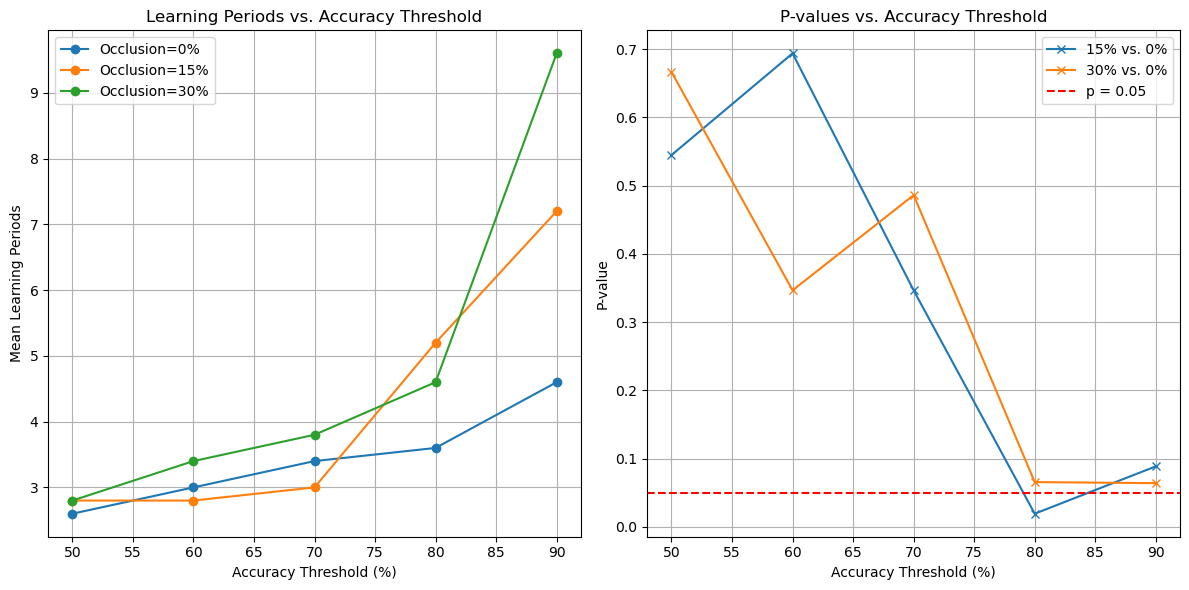

In [284]:
plot_occlusion_threshold_matrix(summary_occlusion_thresholds, THRESHOLDS)

______

End of notebook :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>